# Literature review

Conducts the statistical analysis of the literature review (Section 4.1) and produces the respective figures.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from itertools import product
import matplotlib.colors as mcolors
import matplotlib.ticker as mtick

In [ ]:
# #Set all matplotlib fonts to Lato
plt.rcParams['font.family'] = 'Lato'

# # In case automatic Lato font detection does not work, add them after downloading manually
# from matplotlib import font_manager as fm
# fonts = [
#     "Lato-Regular.ttf",
#     "Lato-Italic.ttf",
#     "Lato-Bold.ttf",
#     "Lato-BoldItalic.ttf",
# ]

# font_dir = "/home/nielja/.local/share/fonts/lato/"
# for f in fonts:
#     fm.fontManager.addfont(font_dir + f)

# # Now matplotlib knows them
# plt.rcParams["font.family"] = "Lato"  # works if the names inside the files are consistent


In [8]:
#Set starting folder to the correct one
os.chdir('/home/nielja/Code/publication/')

## Data preparation

In [23]:
#Load lit review file
df = pd.read_excel('./data/raw/literature_review/25_02_24_exported_refs_working_doc.xlsx')

/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [24]:
#Keep only the papers that were included in the second round of screening
df = df.loc[df['INCLUDE second round'] == True]

#Classify the data sources and EWS approaches
df['data_source_rs'] = df['Data source'].str.contains('atellite')
df['data_source_tree_ring'] = df['Data source'].str.contains('ring')
df['data_source_mechanistic'] = df['Data source'].str.contains('echanistic')

#For all those that are neither of those, assign other as true
df['data_source_other'] = ~df['data_source_rs'] & ~df['data_source_tree_ring'] & ~df['data_source_mechanistic']

#Compute how many data sources were used
df['data_source_sum'] = df['data_source_rs'].astype(int) + df['data_source_tree_ring'].astype(int) + df['data_source_mechanistic'].astype(int) + df['data_source_other'].astype(int)

#Binary columns for different data sources
df['data_source'] = ''
df.loc[df['data_source_mechanistic'], 'data_source'] = 'Mechanistic'
df.loc[df['data_source_rs'], 'data_source'] = 'Remote sensing'
df.loc[df['data_source_tree_ring'], 'data_source'] = 'Tree rings'
df.loc[df['data_source_other'], 'data_source'] = 'Other'
df.loc[df['data_source_sum'] == 2, 'data_source'] = 'Remote sensing\n & tree rings'

#Also make a second column for data_source_short
df['data_source_short'] = df['data_source']
df.loc[df['data_source'] == 'Remote sensing\n & tree rings', 'data_source_short'] = 'RS\n& tree rings'
df.loc[df['data_source'] == 'Remote sensing', 'data_source_short'] = 'RS'

#Classify the drivers
df['driver_temp'] = df['Dieback drivers'].str.contains('emperature') |  df['Dieback drivers'].str.contains('heat') | df['Dieback drivers'].str.contains('Heat')
df['driver_prec'] = df['Dieback drivers'].str.contains('recipitation') | df['Dieback drivers'].str.contains('ainfall') | df['Dieback drivers'].str.contains('water') 
df['driver_drought'] = df['Dieback drivers'].str.contains('drought') | df['Dieback drivers'].str.contains('Drought')
df['driver_fire'] = df['Dieback drivers'].str.contains('fire') | df['Dieback drivers'].str.contains('Fire')
df['driver_pest'] = df['Dieback drivers'].str.contains('insect') | df['Dieback drivers'].str.contains('Insect')| df['Dieback drivers'].str.contains('pest') | df['Dieback drivers'].str.contains('Pest') | df['Dieback drivers'].str.contains('beetle') | df['Dieback drivers'].str.contains('Beetle') | df['Dieback drivers'].str.contains('istletoe') | df['Dieback drivers'].str.contains('ungi')
df['driver_lulc'] = df['Dieback drivers'].str.contains('and use') | df['Dieback drivers'].str.contains('andcover') | df['Dieback drivers'].str.contains('eforestation') | df['Dieback drivers'].str.contains('Grazing')
df['driver_other'] = ~df['driver_temp'] & ~df['driver_prec'] & ~df['driver_drought'] & ~df['driver_fire'] & ~df['driver_pest'] & ~df['driver_lulc']

## Analysis & plots

In [25]:
# Total number of papers
print(f"Total number of papers included in the review: {len(df)}")

Total number of papers included in the review: 64


### Data source overview

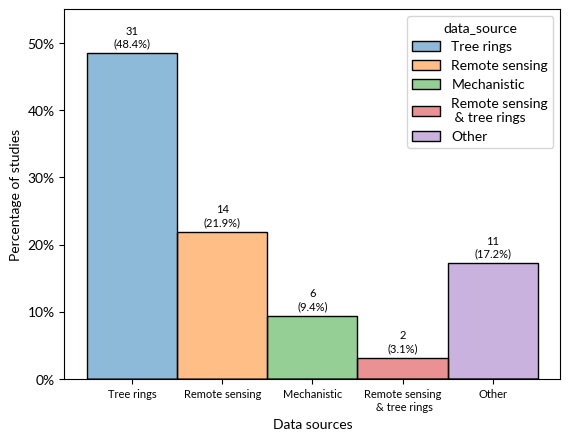

In [26]:
#Hist of different data sources, sorted by size

#Sort data_source categories by size
data_source_order = df.groupby('data_source').size().sort_values(ascending = False).index
#Put "Other" at the end
data_source_order = data_source_order[data_source_order != 'Other']
data_source_order = np.append(data_source_order, 'Other')

#Set as categorical
df['data_source'] = pd.Categorical(df['data_source'], data_source_order)

#Also make data_source_short categorical
data_source_short_order = df.groupby('data_source_short').size().sort_values(ascending = False).index
data_source_short_order = data_source_short_order[data_source_short_order != 'Other']
data_source_short_order = np.append(data_source_short_order, 'Other')
df['data_source_short'] = pd.Categorical(df['data_source_short'], data_source_short_order)

#Plot
ax = sns.histplot(df, x = 'data_source', hue = 'data_source', stat ='density')
ax.set(xlabel = 'Data sources', ylabel = 'Percentage of studies')
#Add labels of counts and percentages 
for p in ax.patches:
    height = p.get_height()
    if not height == 0:
        ax.text(p.get_x() + p.get_width()/2., height + 0.01, '{:1.0f}\n({:1.1f}%)'.format(height*len(df), height*100), ha="center", fontsize = 8)
plt.xticks(fontsize = 8)
ax.set_ylim(0, 0.55)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

### Final plot

In [28]:
# Data preparation for plotting
df['data_source_agg'] = df.data_source
#Revert data_source back to string
df['data_source'] = df['data_source'].astype(str)
df['data_source_agg'] = df['data_source_agg'].astype(str)
df.loc[df['data_source'].isin(['Remote sensing\n & tree rings', 'Other']), 'data_source_agg'] = 'Other or multiple'
df_source = df.groupby('data_source_agg').size().reset_index(name='count')
df_source['count_scaled'] = df_source['count'] / df_source['count'].sum()*101  # Normalize counts to fractions
df_source['group'] = 'Data Source'


#Color dict based on cmap
def create_color_dict(df, column='data_source_agg', cmap_name='tab10'):
    """
    Create a color dictionary mapping unique values in a column to colors from a colormap.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        column (str): The name of the column with categorical values.
        cmap_name (str): Name of the Matplotlib colormap to use.

    Returns:
        dict: A dictionary mapping each unique value to a hex color.
    """
    unique_vals = sorted(df[column].unique())
    if type(cmap_name) is str:

        cmap = plt.get_cmap(cmap_name)
        n = len(unique_vals)
        colors = [mcolors.to_hex(cmap(i / max(n - 1, 1))) for i in range(n)]
    else:
        colors = cmap_name
    return dict(zip(unique_vals, colors))

# Create color dictionary for data sources
colors = create_color_dict(df_source, column='data_source_agg', cmap_name=reversed(['#C2DAAA', '#92C9C9' , '#bfa07aa4', '#E5D48B' ])) #['olivedrab', 'skyblue', 'silver', 'goldenrod'])) #


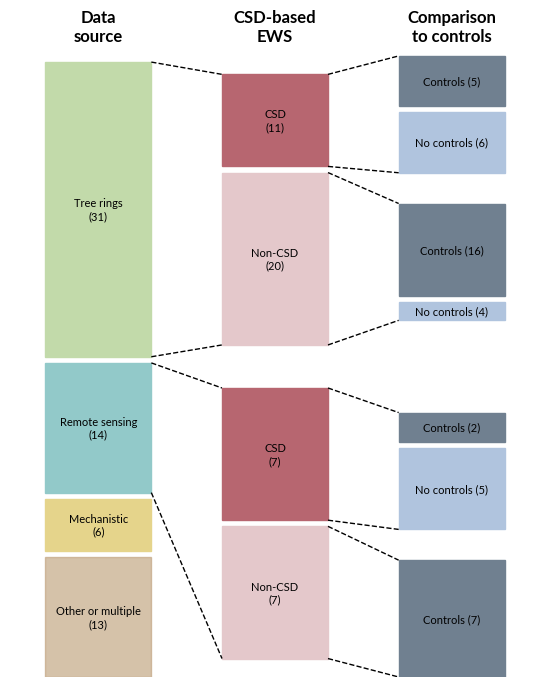

In [34]:
#Final plot setup
fig, ax = plt.subplots(figsize = (5.6, 7))

#Plot first column
white_space = 1
bottom = 0
width = .6
for data_source in ['Other or multiple', 'Mechanistic', 'Remote sensing', 'Tree rings']:
    height = df_source.loc[df_source['data_source_agg'] == data_source, 'count_scaled'].values[0]
    ax.bar(0, height - white_space, bottom = bottom, width=width, color=colors[data_source], edgecolor = colors[data_source], linewidth=1)
    #Add text in the middle
    ax.text(0, bottom + height/2 - white_space/2, f'{data_source}\n({df_source.loc[df_source["data_source_agg"] == data_source, "count"].values[0]:.0f})', ha='center', va='center', fontsize=8)
    bottom += height
    if data_source == 'Mechanistic':
        bottom_rs = bottom
    elif data_source == 'Remote sensing':
        bottom_tr = bottom
    elif data_source == 'Tree rings':
        top_left = bottom

#Plot second column
df_second = df.loc[df.data_source_agg.isin(['Remote sensing', 'Tree rings'])].groupby(['data_source_agg', 'CSD EWS']).size().reset_index(name='count')
#Normalize counts to fraction within category
df_second = df_second.merge(df_second.groupby('data_source_agg')['count'].sum().reset_index(name = 'count_sum'))  # Normalize counts to fractions
df_second['count_scaled'] = df_second['count'] / df_second['count_sum']*45  # Normalize counts to fractions
#Go through the columns for the second plot

#RS first
bottom_0 = 3
bottom = bottom_0
csd_labels = dict(zip([0, 1], ['Non-CSD', 'CSD']))
top_line_center = []
color_csd ={0:  '#E4C8CB', 1:'#B76670'}# {0: 'pink', 1: 'rosybrown'}  # Define colors for CSD EWS
for data_source in ['Remote sensing', 'Tree rings']:
    for csd in [0, 1]:
    
        height = df_second.loc[(df_second['data_source_agg'] == data_source) & (df_second['CSD EWS'] == csd), 'count_scaled'].values[0]
        ax.bar(1, height - white_space, bottom = bottom, width=width, color=color_csd[csd], edgecolor = color_csd[csd], linewidth=1)
        #Add text in the middle
        ax.text(1, bottom + height/2 - white_space/2, f'{csd_labels[csd]}\n({ df_second.loc[(df_second["data_source_agg"] == data_source) & (df_second["CSD EWS"] == csd), "count"].values[0]:.0f})', ha='center', va='center', fontsize=8)
        bottom += height
        top_line_center.append(bottom - white_space)
    #Add a bigger white space in the middle
    bottom += 6
    if data_source == 'Remote sensing':
        bottom_right_tr = bottom
bottom_final_right = bottom
    


#Third column with true or false
df_third = df.loc[df.data_source_agg.isin(['Remote sensing', 'Tree rings'])].groupby(['data_source_agg', 'CSD EWS', 'Comparison to true negatives']).size().reset_index(name='count')
#Normalize by data source and EWS
df_third = df_third.merge(df_third.groupby(['data_source_agg', 'CSD EWS'])['count'].sum().reset_index(name = 'count_sum'))  # Normalize counts to fractionsq
df_third['count_scaled'] = df_third['count'] / df_third['count_sum']*20  # Normalize counts to fractions

bottom = 0
color_control ={0 : 'lightsteelblue', 1 : 'slategray'} # #
control_labels = dict(zip([0, 1], ['No controls', 'Controls']))
in_group_space = 4
between_group_space = 10
csd_top_val = []
for data_source in ['Remote sensing', 'Tree rings']:
    for csd in [0, 1]:
        for control in [0, 1]:
            if len(df_third.loc[(df_third['data_source_agg'] == data_source) & (df_third['CSD EWS'] == csd) & (df_third['Comparison to true negatives'] == control)]) == 0:
                continue
            else:
                height = df_third.loc[(df_third['data_source_agg'] == data_source) & (df_third['CSD EWS'] == csd) & (df_third['Comparison to true negatives'] == control), 'count_scaled'].values[0]
                ax.bar(2, height - white_space, bottom = bottom, width=width, color=color_control[control], edgecolor = color_control[control], linewidth=1)
                #Add text
                ax.text(2, bottom + height/2 - white_space/2, f'{control_labels[control]} ({df_third.loc[(df_third["data_source_agg"] == data_source) & (df_third["CSD EWS"] == csd) & (df_third["Comparison to true negatives"] == control), "count"].values[0]:.0f})', ha='center', va='center', fontsize=8)
                bottom += height
        csd_top_val.append(bottom - white_space)
        #Add a bigger white space in the middle
        bottom += in_group_space
    bottom += between_group_space
    


#Add dashed lines connecting the two columns
ax.plot([width/2, 1 - width/2], [bottom_rs, 3], color='black', linestyle='--', linewidth=1)
ax.plot([width/2, 1 - width/2], [bottom_tr - white_space, 48 - white_space], color='black', linestyle='--', linewidth=1)
#lines for the top part
ax.plot([width/2, 1 - width/2], [bottom_tr, bottom_right_tr], color='black', linestyle='--', linewidth=1)
ax.plot([width/2, 1 - width/2], [top_left - white_space, bottom_final_right - 6 - white_space], color='black', linestyle='--', linewidth=1)

#Add dashed lines from center to right
ax.plot([1 + width/2, 2 - width/2], [3, 0], color='black', linestyle='--', linewidth=1)
ax.plot([1 + width/2, 2 - width/2], [top_line_center[0], csd_top_val[0]], color='black', linestyle='--', linewidth=1)
ax.plot([1 + width/2, 2 - width/2], [top_line_center[0] + white_space, csd_top_val[0] + in_group_space + white_space], color='black', linestyle='--', linewidth=1)
ax.plot([1 + width/2, 2 - width/2], [top_line_center[1], csd_top_val[1]], color='black', linestyle='--', linewidth=1)
ax.plot([1 + width/2, 2 - width/2], [top_line_center[1] + 6 + white_space, csd_top_val[1] + between_group_space + in_group_space + white_space], color='black', linestyle='--', linewidth=1)
ax.plot([1 + width/2, 2 - width/2], [top_line_center[2], csd_top_val[2]], color='black', linestyle='--', linewidth=1)
ax.plot([1 + width/2, 2 - width/2], [top_line_center[2] + white_space, csd_top_val[2] + in_group_space + white_space], color='black', linestyle='--', linewidth=1)
ax.plot([1 + width/2, 2 - width/2], [top_line_center[3], csd_top_val[3]], color='black', linestyle='--', linewidth=1)

#Add text at the top
text_height = 103
ax.text(0, text_height, 'Data\nsource', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax.text(1, text_height, 'CSD-based\nEWS', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax.text(2, text_height, 'Comparison\nto controls', ha='center', va='bottom', fontsize=12, fontweight='bold')

#Set limits and turn off axes
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(0, 105)
ax.axis('off')

#Save figure
plt.tight_layout()

#Create output folder if it does not exist yet
output_folder = './plots/'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
plt.savefig(os.path.join(output_folder, '00_literature_review.png'), dpi = 700, bbox_inches='tight')

In [35]:
# Show these results as table as well
df_overview = df.groupby(['data_source_agg', 'CSD EWS', 'Comparison to true negatives']).size().reset_index(name='Absolute count')

#Rename columns
df_overview.columns = ['Data source', 'CSD-based EWS', 'Comparison to controls', 'Absolute count']
#Make binary columns to string
df_overview['CSD-based EWS'] = df_overview['CSD-based EWS'].replace({0: 'Non-CSD', 1: 'CSD'})
df_overview['Comparison to controls'] = df_overview['Comparison to controls'].replace({0: 'No controls', 1: 'Controls'})
#Reorder rows
data_source_order = ['Tree rings', 'Remote sensing', 'Mechanistic', 'Other or multiple']
csd_order = ['Non-CSD', 'CSD']
control_order = ['No controls', 'Controls']
df_overview['CSD-based EWS'] = pd.Categorical(df_overview['CSD-based EWS'], categories=csd_order, ordered=True)
df_overview['Comparison to controls'] = pd.Categorical(df_overview['Comparison to controls'], categories=control_order, ordered=True)
df_overview['Data source'] = pd.Categorical(df_overview['Data source'], categories=data_source_order, ordered=True)
df_overview = df_overview.sort_values('Data source').reset_index(drop=True)


#Add percentage columns, based on 1) all data, 2) data source, 3) data source and CSD
total_count = df_overview['Absolute count'].sum()
df_overview['Percentage of all studies (%)'] = df_overview['Absolute count'] / total_count * 100
df_overview['Percentage of data source (%)'] = df_overview['Absolute count'] / df_overview.groupby('Data source', observed = True)['Absolute count'].transform('sum') * 100
df_overview['Percentage of data source and CSD (%)'] = df_overview['Absolute count'] / df_overview.groupby(['Data source', 'CSD-based EWS'], observed = True)['Absolute count'].transform('sum') * 100
#Make all percentage columns to one decimal
df_overview['Percentage of all studies (%)'] = df_overview['Percentage of all studies (%)'].round(1)
df_overview['Percentage of data source (%)'] = df_overview['Percentage of data source (%)'].round(1)
df_overview['Percentage of data source and CSD (%)'] = df_overview['Percentage of data source and CSD (%)'].round(1)

#Show final table
df_overview

Data source CSD-based EWS Comparison to controls  Absolute count  \
0          Tree rings       Non-CSD            No controls               4   
1          Tree rings       Non-CSD               Controls              16   
2          Tree rings           CSD            No controls               6   
3          Tree rings           CSD               Controls               5   
4      Remote sensing       Non-CSD               Controls               7   
5      Remote sensing           CSD            No controls               5   
6      Remote sensing           CSD               Controls               2   
7         Mechanistic       Non-CSD               Controls               1   
8         Mechanistic           CSD            No controls               5   
9   Other or multiple       Non-CSD            No controls               3   
10  Other or multiple       Non-CSD               Controls               9   
11  Other or multiple           CSD               Controls               1   

    Percentage of all studies (%)  Percentage of data source (%)  \
0                             6.2                           12.9   
1                            25.0                           51.6   
2                             9.4                           19.4   
3                             7.8                           16.1   
4                            10.9                           50.0   
5                             7.8                           35.7   
6                             3.1                           14.3   
7                             1.6                           16.7   
8                             7.8                           83.3   
9                             4.7                           23.1   
10                           14.1                           69.2   
11                            1.6                            7.7   

    Percentage of data source and CSD (%)  
0                                    20.0  
1                                    80.0  
2                                    54.5  
3                                    45.5  
4                                   100.0  
5                                    71.4  
6                                    28.6  
7                                   100.0  
8                                   100.0  
9                                    25.0  
10                                   75.0  
11                                  100.0

In [36]:
#Get name of the two papers with RS, CSD & controls
df.loc[((df['data_source'] == 'Remote sensing') & (df['CSD EWS'] == True) & (df['Comparison to true negatives'] == True))][['Authors', 'Publication Year', 'Article Title', 'DOI']]

Authors  Publication Year  \
3                                       Alibakhshi, S              2023   
27  Rogers, BM; Solvik, K; Hogg, EH; Ju, JC; Masek...              2018   

                                        Article Title  \
3   A robust approach and analytical tool for iden...   
27  Detecting early warning signals of tree mortal...   

                              DOI  
3   10.1016/j.ecolind.2023.110983  
27              10.1111/gcb.14107